# **Cats vs Dogs Classification using SVM**


In [29]:
# install dependencies
!pip install torch torchvision scikit-learn pillow matplotlib tqdm


You should consider upgrading via the 'C:\Users\HP\Documents\PRODIGY_INTERSHIP_ML\tf_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [30]:
# Step 1: Imports
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
from glob import glob
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [31]:
# Step 2: Prepare the feature‑extractor (pretrained CNN)
# We'll use ResNet18 
device = torch.device("cpu")  # or "cuda" if you have GPU

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Remove final classification layer — we only want features
model.fc = torch.nn.Identity()
model.eval()
model.to(device)

# Transformation to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(                 # normalization for pretrained models
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [32]:
# Step 3: Helper to extract features from image path
def extract_feature(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        feats = model(img_t)
    return feats.cpu().numpy().flatten()


In [33]:
# Step 4: Prepare dataset paths
cat_paths = glob("train/cats/*.jpg")   # adjust path
dog_paths = glob("train/dogs/*.jpg")

# Optionally limit number (or use all)
cat_paths = cat_paths[:4000]
dog_paths = dog_paths[:4000]

all_paths = cat_paths + dog_paths
labels = [0]*len(cat_paths) + [1]*len(dog_paths)  # 0 = cat, 1 = dog


In [34]:
# Step 5: Extract features for all images
X = []
y = []

from tqdm import tqdm

for p, lbl in zip(all_paths, labels):
    feat = extract_feature(p)
    X.append(feat)
    y.append(lbl)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)


Feature matrix shape: (5587, 512)


In [35]:
# Step 6: Split data into validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [36]:
# Step 7: Train SVM on extracted features
svm = SVC(kernel="rbf", C=10, gamma="scale")
svm.fit(X_train, y_train)


,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [37]:
# Step 8: Evaluate on validation set
y_pred = svm.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {:.2f}%".format(acc*100))


Validation Accuracy: 98.57%


In [38]:
# Step 9: Predict on test images (if you have test folder)
test_paths = glob("test/*.jpg")
test_features = np.array([extract_feature(p) for p in test_paths])
test_pred = svm.predict(test_features)


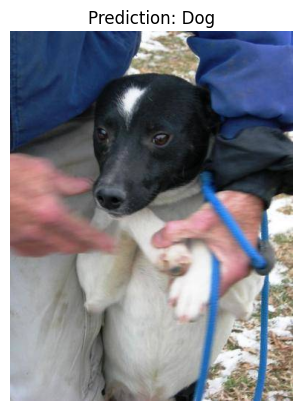

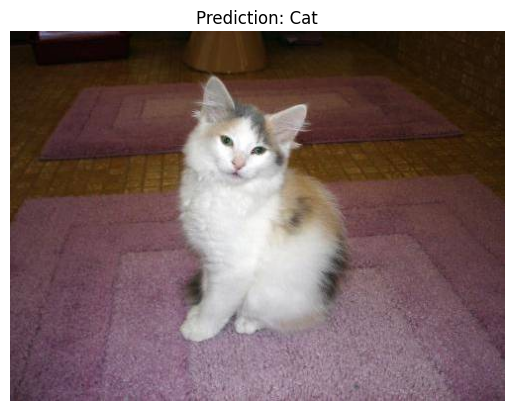

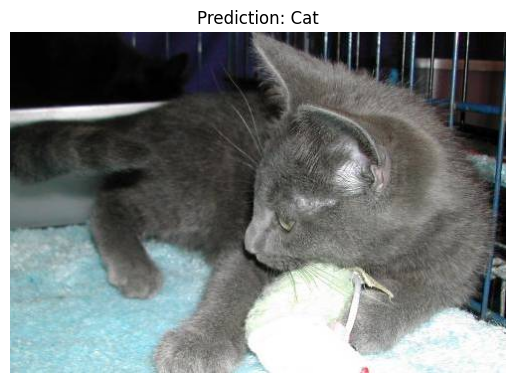

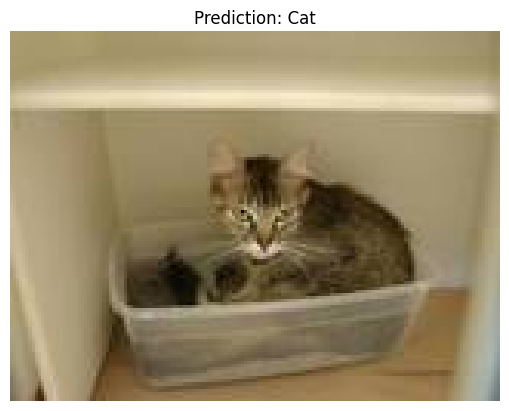

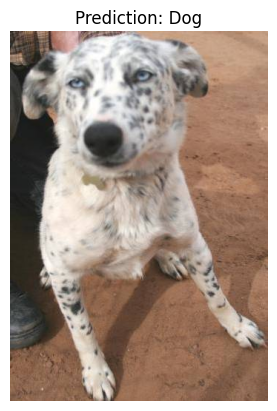

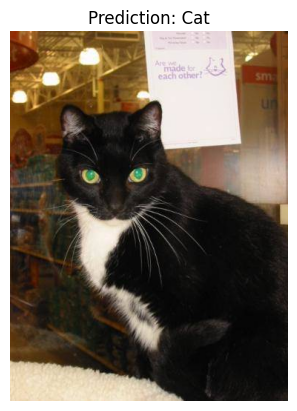

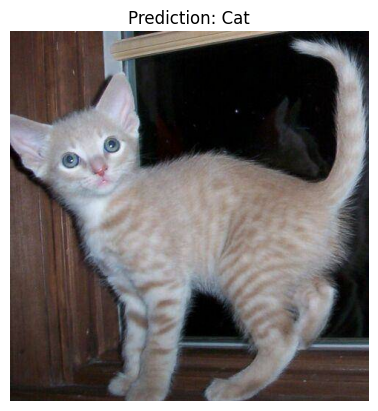

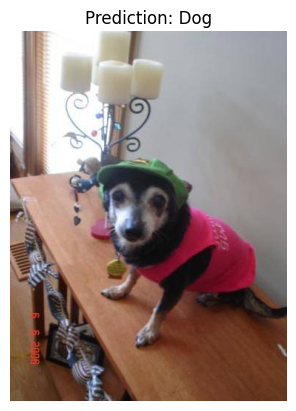

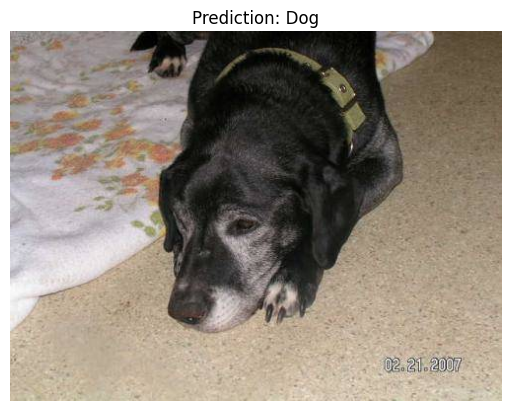

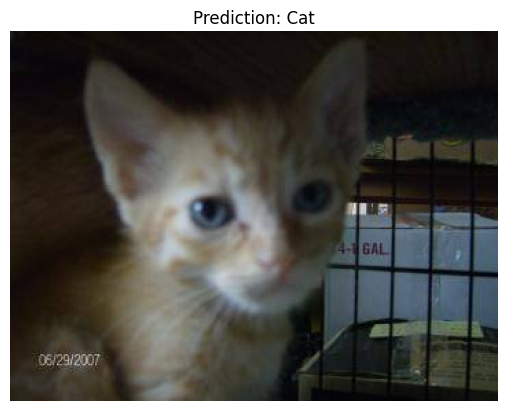

In [39]:
# Step 10: Visualize some predictions
num_show = min(10, len(test_paths))
for i in range(num_show):
    img = Image.open(test_paths[i])
    plt.imshow(img)
    plt.axis("off")
    label = "Dog" if test_pred[i] == 1 else "Cat"
    plt.title(f"Prediction: {label}")
    plt.show()
